# Topic based clustering

The goal of our project is to group YouTube comments together based on their topics.

This notebook will explore different clustering algorithms, benchmark them, and recommend one that is most suitable for our problem.

## Introduction  

### The problem and the goal

**The Problem:**

We need an automated way to group YouTube video comments by their underlying topics based on text embeddings.

Input challageds:
- dynamic
- no pre-defined labels
- unknown number of natural topics (`k`)
- requires fast processing for a user-facing application.

**The Goal:**

This notebook explores and implements clustering strategies that can rapidly process comment embeddings "on the fly". The aim is to find methods that quickly identify meaningful topic clusters for any video. 

Optimizing for internal validation scores:
 - Silhouette
 - Davies-Bouldin
 - Calinski-Harabasz



### Assumptions


This notebook assumes the following: 
- Comments have already been cleaned and encoded. 
- Comments encoding have been reduced into a 2 dimensional space.

Currently, we did not prefect these steps, so here is a short and imperfect implementation of these so we can start working. [link to notebook](./assumptions.ipynb)

> We assume that the data is encoded properly and that by mesuring the distance between comments, we can cluster them based on topics.


### Benchmarks
- Davies-Bouldin
- Silhouette
- Calinski-Harabasz


## Installations

In [ ]:
import sys

!{sys.executable} -m pip install scikit-learn pandas numpy tqdm python-dotenv google-genai plotly matplotlib seaborn

## Algorithms

### Introduction  

Clustering algorithms can be grouped into 4 main categories.

![Clustering Algorithm Categories](./images/clustering%20groups.png)

1.  **Flat vs. Hierarchical Output:** Does the algorithm produce a single partition or a nested structure?
2.  **Core Mechanism:** Is it based on distance to centers (**Centroid/Parametric**) or on data point density (**Density/Non-Parametric**)?

Understanding the strengths of these categories helps guide algorithm selection:

* **Flat & Centroid/Parametric (e.g., KMeans, GMM):**
    * **Strength:** Efficient partitioning into a predefined number (`k`) of typically globular/elliptical clusters. Good for large datasets when `k` is known and shapes are simple.
* **Hierarchical & Centroid/Parametric (e.g., Ward, Agglomerative Linkages):**
    * **Strength:** Reveals nested cluster structures (dendrogram), useful for exploring different granularities without fixing `k` initially. Ward linkage is good for finding compact, balanced clusters within the hierarchy.
* **Flat & Density/Non-Parametric (e.g., DBSCAN, Mean Shift):**
    * **Strength:** Discovering arbitrarily shaped clusters and identifying noise without needing `k` upfront. Effective when density defines groups better than proximity to a center.
* **Hierarchical (Internal) & Density/Non-Parametric (e.g., HDBSCAN):**
    * **Strength:** Robustly finds arbitrarily shaped clusters of varying densities, handles noise, and automatically determines a suitable number of clusters (`k`) based on stability. Excellent for exploration when `k` and shapes are unknown. (Note: Outputs a flat partition).


### Utills

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets


In [ ]:
def generate_datasets(n_samples=500, random_state=76):
    datasets_dict = {}

    X_blobs, y_blobs = datasets.make_blobs(
        n_samples=n_samples, centers=3, cluster_std=0.8, random_state=random_state
    )
    datasets_dict['Blobs'] = (X_blobs, y_blobs)

    X_moons, y_moons = datasets.make_moons(
        n_samples=n_samples, noise=0.05, random_state=random_state
    )
    datasets_dict['Moons'] = (X_moons, y_moons)

    X_circles, y_circles = datasets.make_circles(
        n_samples=n_samples, factor=0.5, noise=0.05, random_state=random_state
    )
    datasets_dict['Circles'] = (X_circles, y_circles)

    X_varied, y_varied = datasets.make_blobs(
        n_samples=n_samples,
        centers=[[1, 1], [-2, -2], [3, -1]],
        cluster_std=[0.5, 1.5, 0.3],
        random_state=random_state
    )
    datasets_dict['Varied Blobs'] = (X_varied, y_varied)

    X_aniso, y_aniso = datasets.make_blobs(
        n_samples=n_samples, centers=3, random_state=random_state
    )
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X_aniso, transformation)
    datasets_dict['Anisotropic Blobs'] = (X_aniso, y_aniso)

    X_noise = np.random.rand(n_samples, 2) * 10
    datasets_dict['No Structure (Noise)'] = (X_noise, None)

    print(f"Generated datasets: {list(datasets_dict.keys())}")
    return datasets_dict


In [ ]:
print("Generating sample datasets...")
sample_datasets = generate_datasets(n_samples=300)

Generating sample datasets...
Generated datasets: ['Blobs', 'Moons', 'Circles', 'Varied Blobs', 'Anisotropic Blobs', 'No Structure (Noise)']


In [ ]:
def plot_clusters(X, labels, title="Clustering Results", noise_color='lightgrey', palette='viridis', noise_marker='x', figsize=(8, 6)):
    if X.shape[1] != 2:
        print("Warning: Plotting function currently only supports 2D data.")
        return

    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

    plt.figure(figsize=figsize)

    if n_clusters > 0:
        colors = sns.color_palette(palette, n_colors=n_clusters)
        label_color_map = {label: colors[i] for i, label in enumerate(sorted(l for l in unique_labels if l != -1))}
    else:
        label_color_map = {}

    label_color_map[-1] = noise_color

    is_noise = (labels == -1)
    if np.any(is_noise):
        plt.scatter(X[is_noise, 0], X[is_noise, 1], c=label_color_map[-1], marker=noise_marker, label='Noise', alpha=0.5, s=30, zorder=1)

    for label, color in label_color_map.items():
        if label == -1: continue
        cluster_points = X[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, label=f'Cluster {label}', alpha=0.8, s=50, zorder=2)

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    handles, current_labels = plt.gca().get_legend_handles_labels()
    if handles:
      plt.legend(scatterpoints=1, loc='best', ncol=1, fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


In [ ]:
def plot_all_datasets(datasets_dict, model, model_name, grid_shape=(2, 3), figsize=(12, 9), point_size=10, cmap='viridis'):
    rows, cols = grid_shape
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    dataset_items = list(datasets_dict.items())

    for i, ax in enumerate(axes):
        if i < len(dataset_items):
            name, (X, y_true) = dataset_items[i]

            try:
                model.fit(X)
                y_pred = model.labels_
            except Exception as e:
                print(f"Error fitting model to dataset '{name}': {e}")
                y_pred = None

            if y_pred is not None:
                unique_labels = set(y_pred)
                if -1 in unique_labels:
                    noise_mask = (y_pred == -1)
                    scatter = ax.scatter(X[~noise_mask, 0], X[~noise_mask, 1], c=y_pred[~noise_mask], 
                                        cmap='viridis', s=point_size, alpha=0.7)
                    ax.scatter(X[noise_mask, 0], X[noise_mask, 1], c='gray', s=point_size, alpha=0.5)
                else:
                    scatter = ax.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', s=point_size, alpha=0.7)
            else:
                scatter = ax.scatter(X[:, 0], X[:, 1], s=point_size, alpha=0.7, color='gray')

            ax.set_title(f"{name}")
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Set limits to exactly match the data range
            x_min, x_max = X[:, 0].min(), X[:, 0].max()
            y_min, y_max = X[:, 1].min(), X[:, 1].max()
            
            # Add minimal padding (1%) to prevent points from touching the edge
            x_padding = 0.01 * (x_max - x_min)
            y_padding = 0.01 * (y_max - y_min)
            
            ax.set_xlim(x_min - x_padding, x_max + x_padding)
            ax.set_ylim(y_min - y_padding, y_max + y_padding)
            ax.set_aspect('equal')
            
            # Keep borders visible
            for spine in ax.spines.values():
                spine.set_visible(True)
        else:
            ax.axis('off')

    plt.suptitle(f"Clustering Results using {model_name}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

### Exploring HDBSCAN


#### Why HDBSCAN is a Good Fit Here

HDBSCAN stands out as a strong candidate for clustering YouTube comment embeddings for several key reasons:

* **Finds Number of Clusters (`k`) Automatically:** Unlike KMeans, it figures out the most stable number of clusters based on the data's density, which is essential when `k` is unknown and varies between videos.
* **Handles Complex Clusters:** As a density-based method, it can find clusters of various shapes and densities, which is useful as topic clusters in embedding space might not be simple spheres.
* **Identifies Noise:** It explicitly labels outlier or irrelevant comments as noise (-1), separating them from the core topic clusters.
* **Robust & Flexible:** It generally requires less sensitive parameter tuning than similar methods like DBSCAN and fits well when we don't want to assume simple cluster shapes or a fixed `k`.

#### How HDBSCAN Works (Conceptual Overview)



HDBSCAN refines density-based clustering by creating a cluster hierarchy and selecting the most *stable* groups. Here’s the essence:

1.  **Adjust Distances based on Density:**
    * Calculates **core distance** for each point `x` (distance to its k-th neighbor, reflecting local density):
        $$ \text{core}_k(x) = d(x, \text{k-th NN of } x) $$
    * Computes **mutual reachability distance** between points `a` and `b`, using core distances to effectively shorten distances within dense regions compared to sparse ones:
        $$ d_{\text{mreach}-k}(a, b) = \max(\text{core}_k(a), \text{core}_k(b), d(a, b)) $$

![DBSCAN gif 1](./images/DBSCAN_GIF_1.gif) ![DBSCAN gif 2](./images/DBSCAN_gif_2.gif)


2.  **Build Hierarchy from Dense Connections:**
    * Constructs a Minimum Spanning Tree (MST) using mutual reachability distances, connecting points primarily through dense areas.
    * Creates a hierarchy of potential clusters by simulating splits in the MST as the distance threshold increases (like varying `epsilon` in DBSCAN*).

    ![hiracical gif](./images/hierarch_gif_1.gif)

3.  **Select Stable Clusters:**
    * Prunes the hierarchy based on `min_cluster_size` (removing tiny, insignificant splits).
    * **Key Step:** Measures cluster **stability** – essentially, how long a cluster persists across a range of density levels ($\lambda = 1/\text{distance}$). Stability can be approximated by summing individual point persistence within the cluster:
        $$ \text{Stability}(C) \approx \sum_{p \in C} (\lambda_{p, \text{leaves}} - \lambda_{C, \text{birth}}) $$
    * It extracts the clusters that maximize this stability metric. Points not part of any selected stable cluster are designated as noise (-1).

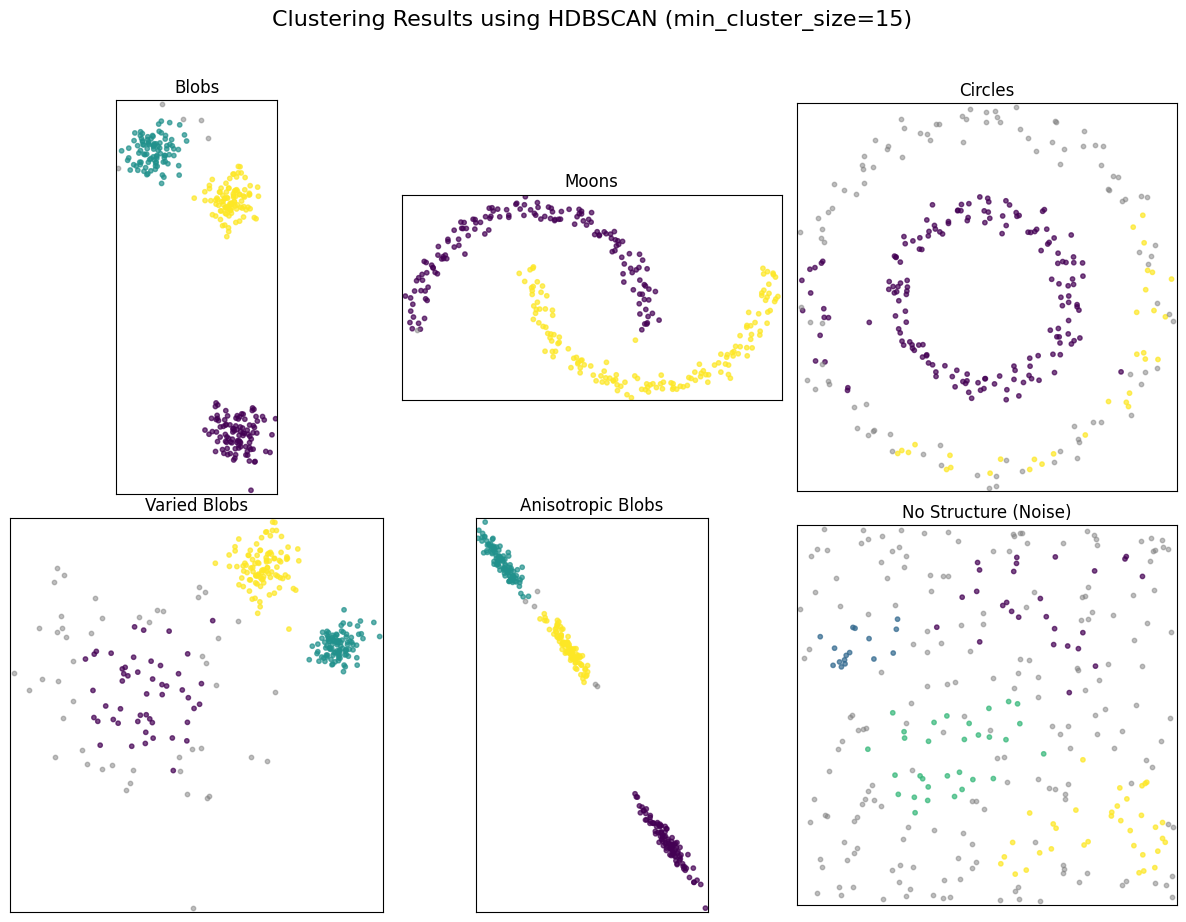

In [ ]:
from sklearn.cluster import HDBSCAN

hdbscan_model_instance = HDBSCAN(
    min_cluster_size=15,    
    metric='euclidean',      
)

hdbscan_model_name = "HDBSCAN (min_cluster_size=15)"


plot_all_datasets(
    datasets_dict=sample_datasets,
    model=hdbscan_model_instance,
    model_name=hdbscan_model_name
)

### Exploring Mini Batch K-Means

#### Why Mini batch k-means Might Be a Good Fit

* **Speed:** This is its main advantage. It processes data in small batches, making it significantly faster than standard KMeans and often faster than density-based methods, especially as the number of comments increases. This directly addresses the "on the fly" processing requirement.
* **Scalability:** Uses much less memory than batch KMeans, making it suitable even if a video has a very large number of comments.
* **Simplicity:** It's a variation of the well-understood KMeans algorithm.

**Considerations:**

* **Requires `k`:** Like standard KMeans, you must specify the number of clusters (`k`). Our strategy would involve quickly testing a small, predefined set of `k` values within the `fit` process and choosing the best based on internal metrics.
* **Cluster Shape:** It assumes clusters are roughly spherical, which might be a limitation compared to HDBSCAN if comment topics form more complex shapes in the embedding space.


#### How Mini batch k-means works (Conceptual Overview)

1.  **Initialize Centroids:** Starts by initializing `k` cluster centroids, similar to standard KMeans (e.g., randomly or using k-means++).

2.  **Iterative Refinement using Mini-Batches:** This is where it differs significantly from standard KMeans:
    * **a) Draw Mini-Batch:** Instead of using the *entire dataset* in each step, it randomly samples a small subset of the data called a **mini-batch**.
    * **b) Assign Batch Points:** Points *within the current mini-batch* are assigned to their nearest centroid.
    * **c) Update Affected Centroids:** The positions of the centroids that received points from the mini-batch are updated. Unlike standard KMeans which recalculates the mean using *all* points at the end of an iteration, MiniBatchKMeans performs an *online update*. For each point `x` in the mini-batch assigned to centroid `c_i`:
        * The algorithm typically maintains a count `v_i` of points assigned to cluster `i` so far. Increment `v_i`.
        * Calculate a per-point learning rate, often `\eta = 1 / v_i`.
        * Update the centroid `c_i` by moving it slightly towards the new point `x`:
            $$ c_i \leftarrow (1 - \eta) c_i + \eta x $$
        This performs a running average, giving less weight to newer points as more points have been assigned to the cluster, helping stabilize the centroid position.
        
3.  **Repeat:** Steps 2a-2c are repeated with new random mini-batches until the centroids stabilize or a maximum number of iterations is reached.

![kmeans_gif](./images/kmeans_gif.gif)


**Key Differences from Standard KMeans:**
* **Data per Iteration:** Uses small batches vs. the full dataset.
* **Centroid Update:** Based on batch points (+ learning rate) vs. mean of all assigned points.
* **Result:** Significantly faster and uses less memory, but the final centroid positions (and cluster assignments) might be slightly different and the inertia (sum of squared distances) potentially higher than batch KMeans due to the approximation. However, results are often very similar in practice.

![mini_batch_vs_kmeans](./images/mini_batch_kmeans_vs_kmeans.png)

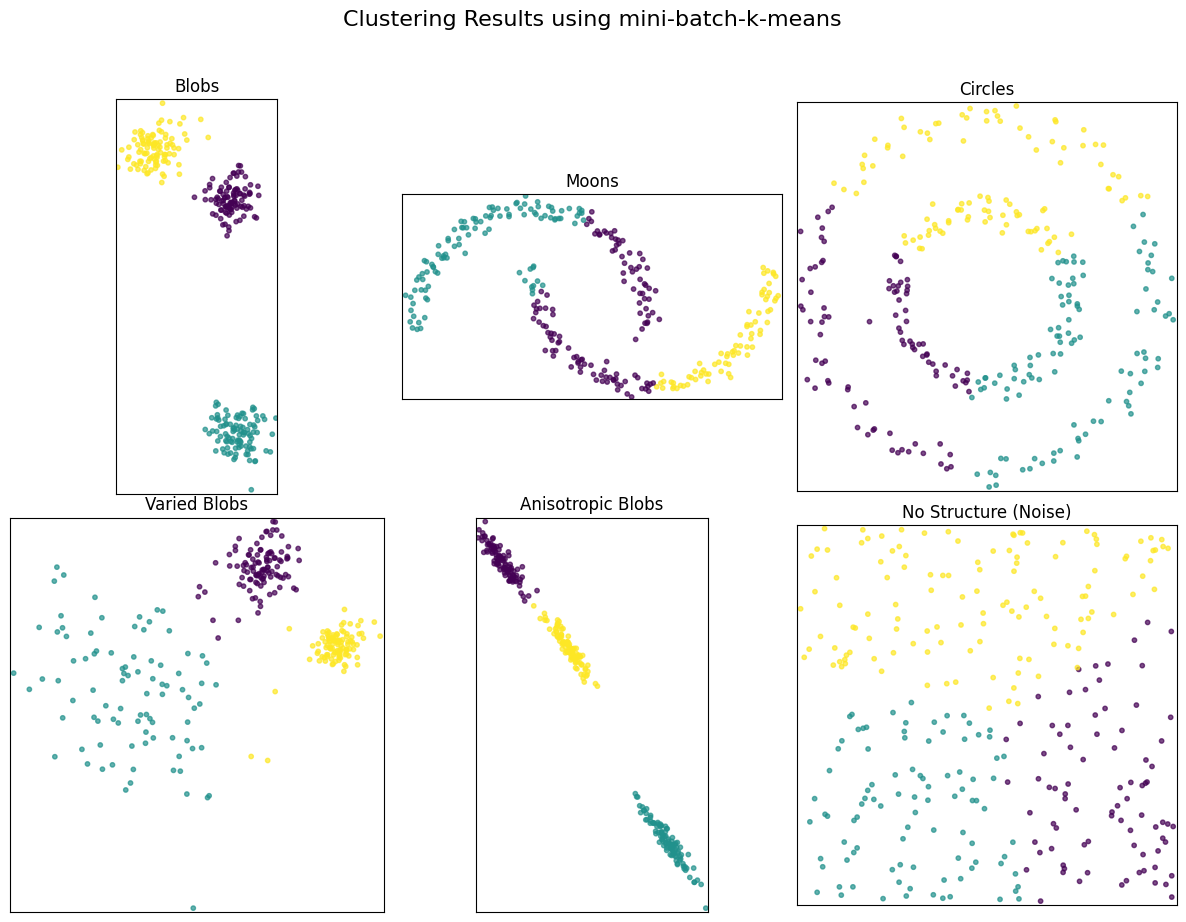

In [ ]:
from sklearn.cluster import MiniBatchKMeans

mbk_model = MiniBatchKMeans(
    init="k-means++",
    n_clusters=3,
    batch_size=75,
    n_init=10,
    max_no_improvement=5,
    verbose=0,
)

mkb_model_name = "mini-batch-k-means"

plot_all_datasets(
    datasets_dict=sample_datasets,
    model=mbk_model,
    model_name=mkb_model_name
)

## Clustering preformance evaluation

In this section we explore how to evaluate clustering results when we have no true labels. We generate a synthetic dataset, visualize it using Plotly, then cluster it in different ways. The key question is: **How will we know which clustering is the best?**  
We answer that by comparing evaluation metrics:
- **Silhouette Score**: Measures how similar a point is to its own cluster versus other clusters (range: -1 to 1; higher is better).
- **Davies-Bouldin Index**: Quantifies the average similarity between each cluster and its most similar one (lower is better).
- **Calinski-Harabasz Index**: Computes the ratio of between-cluster dispersion to within-cluster dispersion (higher is better).

We also show how to optimize the clustering (i.e., choosing the number of clusters) using these metrics.  


### Setup and Data Generation

In [ ]:
import numpy as np
import plotly.express as px
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

def generate_data(n_samples=400, centers=5, random_state=20):
    """Generate synthetic data using make_blobs."""
    X, _ = make_blobs(n_samples=n_samples, centers=centers, random_state=random_state)
    return X

def plot_data(X, labels=None, title="Data Visualization"):
    """Plot data using Plotly."""
    if labels is None:
        fig = px.scatter(x=X[:, 0], y=X[:, 1], title=title)
    else:
        fig = px.scatter(x=X[:, 0], y=X[:, 1], color=labels.astype(str), title=title)
    fig.show()

X = generate_data()
plot_data(X, title="Original Data")

In [ ]:
from sklearn.cluster import AgglomerativeClustering

def kmeans_cluster_data(X, n_clusters):
    """Cluster data using KMeans."""
    model = KMeans(n_clusters=n_clusters, random_state=42)
    labels = model.fit_predict(X)
    return labels

def cluster_agglomerative(X, n_clusters):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    return model.fit_predict(X)

In [ ]:
labels_fixed = kmeans_cluster_data(X, n_clusters=3)
plot_data(X, labels_fixed, title="k-means Clustering with 3 Clusters")

labels_fixed = kmeans_cluster_data(X, n_clusters=5)
plot_data(X, labels_fixed, title="k-means Clustering with 5 Clusters")

labels_fixed = kmeans_cluster_data(X, n_clusters=10)
plot_data(X, labels_fixed, title="k-means Clustering with 10 Clusters")

In [ ]:
labels_fixed = cluster_agglomerative(X, n_clusters=3)
plot_data(X, labels_fixed, title="agglomerative Clustering with 3 Clusters")

labels_fixed = cluster_agglomerative(X, n_clusters=5)
plot_data(X, labels_fixed, title="agglomerative Clustering with 5 Clusters")

labels_fixed = cluster_agglomerative(X, n_clusters=10)
plot_data(X, labels_fixed, title="agglomerative Clustering with 10 Clusters")

### visualize_optimization_results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

def visualize_optimization_results(X, cluster_range, scores, cluster_func, algorithm_name, score_func, score_name, maximize=True):
    """
    Visualizes clustering optimization results for any evaluation metric.

    It plots:
    - The evaluation score versus the number of clusters.
    - Clustering visualizations for three key cases:
      * Initial (first value in cluster_range)
      * Middle (middle value in cluster_range)
      * Best (based on the provided evaluation metric)
    
    Parameters:
        X : np.array
            The data to be clustered.
        cluster_range : list or range
            A sequence of cluster counts that were evaluated.
        scores : list of float
            The evaluation scores corresponding to each cluster count.
        cluster_func : function
            A clustering function that accepts (X, n_clusters) and returns cluster labels.
        algorithm_name : str
            The name of the clustering algorithm (for labeling plots).
        score_func : function
            A function that calculates the evaluation score given (X, labels).
        score_name : str
            The name of the evaluation metric (e.g., "Silhouette Score").
        maximize : bool (default=True)
            Set True if a higher score is better (e.g., Silhouette Score), or False if lower is better (e.g., Davies-Bouldin Index).
    """
    # Convert cluster_range to a list (if not already)
    cluster_range = list(cluster_range)
    
    # Determine key points: initial, middle, and best cluster counts.
    initial_k = cluster_range[0]
    middle_index = len(cluster_range) // 2
    middle_k = cluster_range[middle_index]
    best_index = np.argmax(scores) if maximize else np.argmin(scores)
    best_k = cluster_range[best_index]
    
    # Print details
    print(f"{algorithm_name} Optimization for {score_name}:")
    print(f"Initial: {initial_k} clusters, {score_name}: {scores[0]:.3f}")
    print(f"Middle: {middle_k} clusters, {score_name}: {scores[middle_index]:.3f}")
    print(f"Best: {best_k} clusters, {score_name}: {scores[best_index]:.3f}")
    
    # Plot the optimization graph using matplotlib.
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, scores, marker='o', label=algorithm_name)
    plt.scatter([initial_k, middle_k, best_k],
                [scores[0], scores[middle_index], scores[best_index]],
                color='red', zorder=5, label='Selected Points')
    plt.xlabel("Number of Clusters")
    plt.ylabel(score_name)
    plt.title(f"{algorithm_name} Optimization Graph ({score_name})")
    plt.legend()
    plt.show()
    
    # Visualize clustering results for the initial, middle, and best cases using Plotly.
    for k, label in zip([initial_k, middle_k, best_k], ["Initial", "Middle", "Best"]):
        cluster_labels = cluster_func(X, k)
        current_score = score_func(X, cluster_labels)
        fig = px.scatter(x=X[:, 0], y=X[:, 1], color=cluster_labels.astype(str),
                         title=f"{algorithm_name} {label} Clustering: {k} Clusters ({score_name} = {current_score:.3f})")
        fig.show()


How do we know wich clustring algorithm is the best? what are the best hyperparameters?

### Silhouette Score Evaluation


The **Silhouette Score** measures how similar a data point is to its own cluster compared to other clusters. For each sample \(i\), the silhouette score is given by:

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$$

where:  
- \(a(i)\) is the average distance between \(i\) and all other points in the same cluster,  
- \(b(i)\) is the minimum average distance from \(i\) to points in a different cluster (i.e., the closest cluster that \(i\) is not a member of).

A higher Silhouette Score (close to 1) indicates that the sample is well matched to its own cluster and poorly matched to neighboring clusters. We use this metric to optimize the clustering (by tuning the number of clusters) and to compare different clustering algorithms.

>  NOTE: Clusters might overlap and it alright in our use case.


KMeans Optimization for Silhouette Score:
Initial: 2 clusters, Silhouette Score: 0.512
Middle: 6 clusters, Silhouette Score: 0.666
Best: 5 clusters, Silhouette Score: 0.753


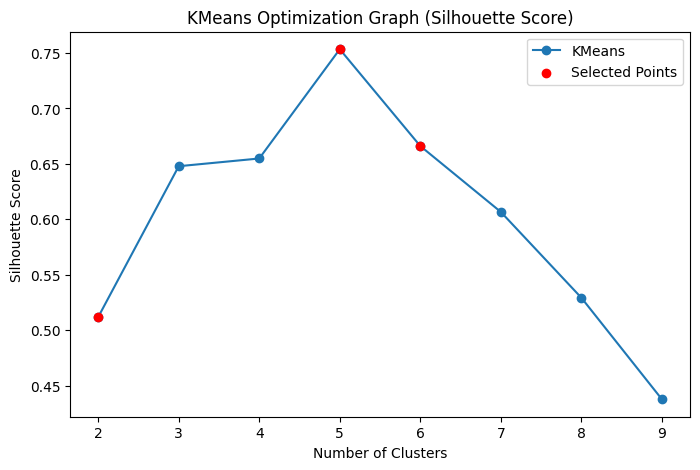

Agglomerative Clustering Optimization for Silhouette Score:
Initial: 2 clusters, Silhouette Score: 0.512
Middle: 6 clusters, Silhouette Score: 0.673
Best: 5 clusters, Silhouette Score: 0.753


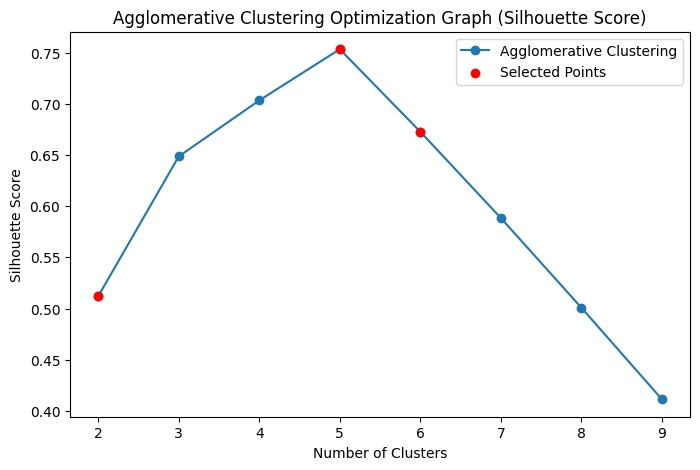

In [ ]:
from sklearn.metrics import silhouette_score

cluster_range = range(2, 10)

scores_kmeans = []
for k in cluster_range:
    labels = kmeans_cluster_data(X, k)
    score = silhouette_score(X, labels)
    scores_kmeans.append(score)

visualize_optimization_results(
    X, 
    cluster_range, 
    scores_kmeans, 
    kmeans_cluster_data, 
    algorithm_name="KMeans", 
    score_func=silhouette_score, 
    score_name="Silhouette Score", 
    maximize=True
)

scores_agg = []
for k in cluster_range:
    labels = cluster_agglomerative(X, k)
    score = silhouette_score(X, labels)
    scores_agg.append(score)

visualize_optimization_results(
    X, 
    cluster_range, 
    scores_agg, 
    cluster_agglomerative, 
    algorithm_name="Agglomerative Clustering", 
    score_func=silhouette_score, 
    score_name="Silhouette Score", 
    maximize=True
)

### Davies-Bouldin


The **Davies-Bouldin Index (DB)** measures the average similarity between each cluster and its most similar (i.e., most overlapping) cluster. It is defined as:

$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left(\frac{s_i + s_j}{d(c_i, c_j)}\right)
$$

where:  
- \(k\) is the number of clusters,  
- \(s_i\) is the average distance between each point in cluster \(i\) and the centroid of cluster \(i\) (a measure of cluster compactness),  
- \(d(c_i, c_j)\) is the distance between the centroids of clusters \(i\) and \(j\).

**Interpretation:**  
A lower Davies-Bouldin Index indicates better clustering performance, as it suggests that clusters are compact and well separated.


KMeans Optimization for Davies-Bouldin:
Initial: 2 clusters, Davies-Bouldin: 0.829
Middle: 6 clusters, Davies-Bouldin: 0.643
Best: 5 clusters, Davies-Bouldin: 0.343


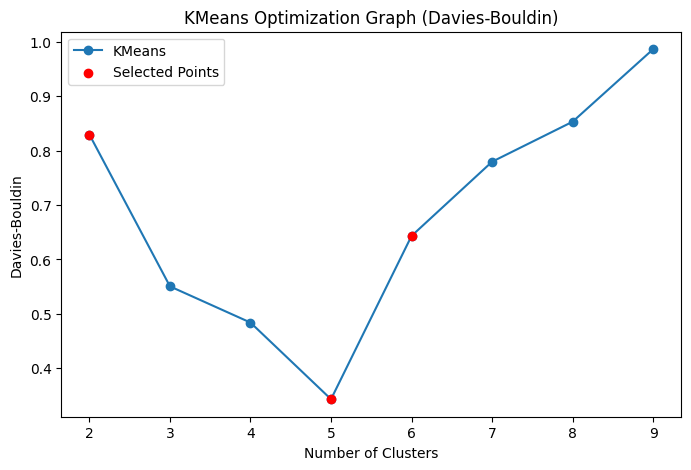

Agglomerative Clustering Optimization for Davies-Bouldin:
Initial: 2 clusters, Davies-Bouldin: 0.829
Middle: 6 clusters, Davies-Bouldin: 0.571
Best: 5 clusters, Davies-Bouldin: 0.343


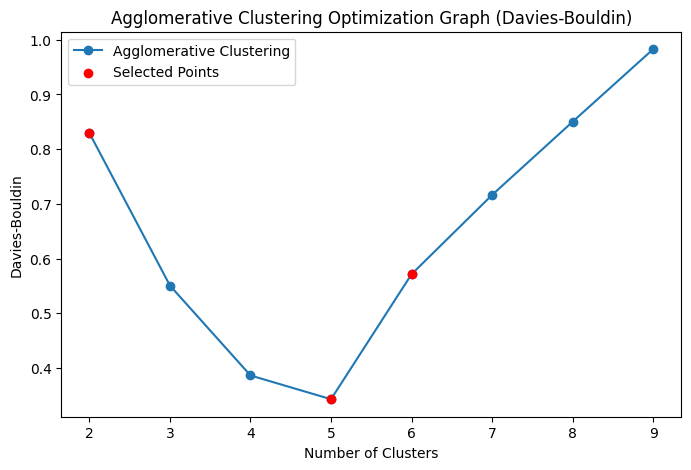

In [ ]:
from sklearn.metrics import davies_bouldin_score

cluster_range = range(2, 10)

scores_kmeans = []
for k in cluster_range:
    labels = kmeans_cluster_data(X, k)
    score = davies_bouldin_score(X, labels)
    scores_kmeans.append(score)

visualize_optimization_results(
    X, 
    cluster_range, 
    scores_kmeans, 
    kmeans_cluster_data, 
    algorithm_name="KMeans", 
    score_func=davies_bouldin_score, 
    score_name="Davies-Bouldin", 
    maximize=False
)

scores_agg = []
for k in cluster_range:
    labels = cluster_agglomerative(X, k)
    score = davies_bouldin_score(X, labels)
    scores_agg.append(score)

visualize_optimization_results(
    X, 
    cluster_range, 
    scores_agg, 
    cluster_agglomerative, 
    algorithm_name="Agglomerative Clustering", 
    score_func=davies_bouldin_score, 
    score_name="Davies-Bouldin", 
    maximize=False
)

### Calinski-Harabasz

The **Calinski-Harabasz Index (CH)**, also known as the Variance Ratio Criterion, evaluates clustering quality by comparing the dispersion between clusters to the dispersion within clusters. It is given by:
$$
CH = \frac{Tr(B_k) / (k - 1)}{Tr(W_k) / (n - k)}
$$

where:  
- \(Tr(B_k)\) is the trace of the between-cluster dispersion matrix,  
- \(Tr(W_k)\) is the trace of the within-cluster dispersion matrix,  
- \(k\) is the number of clusters,  
- \(n\) is the total number of data points.

**Interpretation:**  
A higher Calinski-Harabasz Index indicates better clustering performance, as it implies a higher degree of separation between clusters relative to their compactness.


k-means Clustering Optimization for Calinski-Harabasz Index:
Initial: 2 clusters, Calinski-Harabasz Index: 373.772
Middle: 6 clusters, Calinski-Harabasz Index: 2648.225
Best: 5 clusters, Calinski-Harabasz Index: 3105.064


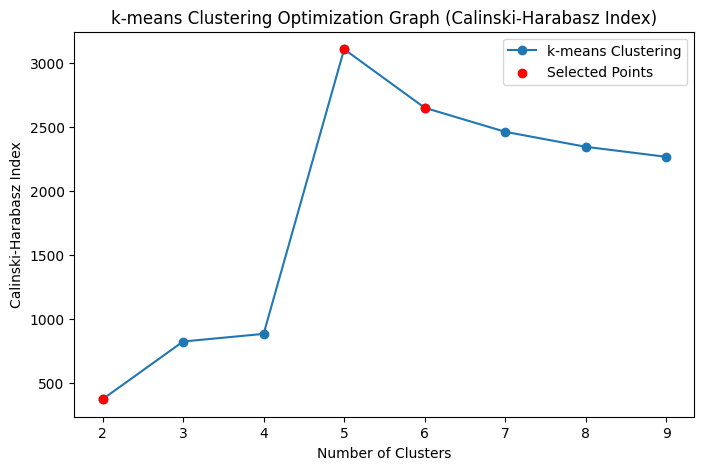

Agglomerative Clustering Optimization for Calinski-Harabasz Index:
Initial: 2 clusters, Calinski-Harabasz Index: 373.772
Middle: 6 clusters, Calinski-Harabasz Index: 2713.438
Best: 5 clusters, Calinski-Harabasz Index: 3105.064


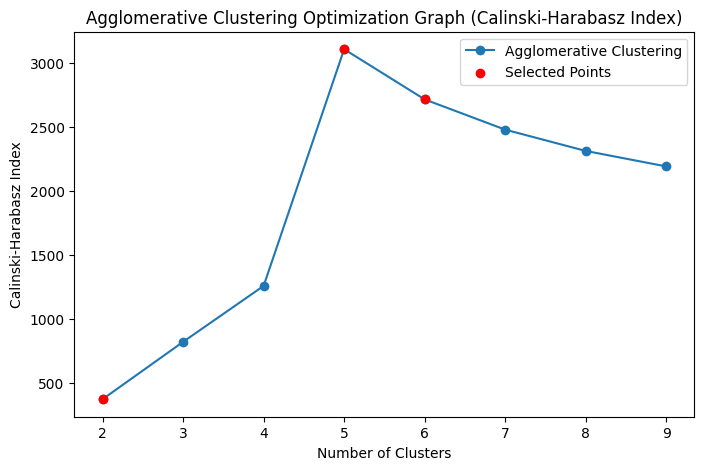

In [ ]:
from sklearn.metrics import calinski_harabasz_score

cluster_range = range(2, 10)


scores_ch_kmeans = []
for k in cluster_range:
    labels = kmeans_cluster_data(X, k)
    score = calinski_harabasz_score(X, labels)
    scores_ch_kmeans.append(score)

visualize_optimization_results(
    X, 
    cluster_range, 
    scores_ch_kmeans, 
    cluster_agglomerative, 
    algorithm_name="k-means Clustering", 
    score_func=calinski_harabasz_score, 
    score_name="Calinski-Harabasz Index", 
    maximize=True
)

scores_ch_agg = []
for k in cluster_range:
    labels = cluster_agglomerative(X, k)
    score = calinski_harabasz_score(X, labels)
    scores_ch_agg.append(score)


visualize_optimization_results(
    X, 
    cluster_range, 
    scores_ch_agg, 
    cluster_agglomerative, 
    algorithm_name="Agglomerative Clustering", 
    score_func=calinski_harabasz_score, 
    score_name="Calinski-Harabasz Index", 
    maximize=True
)

### Summary And Recommendations

When clustering YouTube comments, we face challenges like dynamic data, no pre-defined labels, an unknown number of topics (`k`), and the need for fast processing. Here's a summary of the metrics we considered:

#### Silhouette Coefficient

| Pros                                     | Cons                                     |
| :--------------------------------------- | :--------------------------------------- |
| Provides granular, per-sample evaluation | Sensitive to cluster shape and density   |
| Intuitive range (-1 to +1)              | Computationally moderately expensive   |
| Robust measure of cohesion and separation |                                          |

#### Davies-Bouldin Index

| Pros                                     | Cons                                         |
| :--------------------------------------- | :------------------------------------------- |
| Emphasizes cluster separation             | Assumes convex clusters                    |
| Computationally efficient               | Sensitive to noise and outliers            |
| Provides a global cluster quality measure | Lower values indicate better clustering (less intuitive) |

#### Calinski-Harabasz Index

| Pros                                     | Cons                                           |
| :--------------------------------------- | :--------------------------------------------- |
| Computationally very efficient            | Very sensitive to the number of clusters (`k`) |
| Provides a global cluster quality measure | Assumes convex clusters                      |
| Useful for determining optimal `k`        | Sensitive to cluster shape and density       |

#### Decision: Weighted Average of Silhouette and Davies-Bouldin

Given our constraints, we will proceed with a weighted average of the Silhouette and Davies-Bouldin indices.

**Why?**

* **Complementary Strengths:** Silhouette provides a detailed view of individual sample clustering, while Davies-Bouldin emphasizes overall cluster separation.
* **Robustness:** Combining them mitigates the weaknesses of each individual metric.
* **Relevance:** Both metrics are applicable to our challenge of unknown `k`, as they help assess clustering quality without reliance on pre-defined labels.
* **Computational Efficiency:** While Silhouette is moderately expensive, Davies-Bouldin is efficient. And when used together, they are still fast enough for a user facing application.
* **Normalization:** We will normalize both metrics to a common scale (0 to 1) to ensure they contribute equally to the average.
* **Weighted:** We can add weights to the average, if we determine that one of the metrics is more important to our specific use case.
* **DBSCAN/HDBSCAN Compatibility:** Suitable for evaluating DBSCAN and HDBSCAN, handling non-convex clusters and noise points effectively.

## Benchmarks utills

In [ ]:
import pandas as pd
import os

def create_subdatasets(dataset_path, subsets_amount, subset_size):
    """
    Reads a dataset from a path and splits it into smaller dataframes.
    
    Parameters:
    -----------
    dataset_path : str
        Path to the dataset file
    subsets_amount : int
        Number of subdatasets to create
    subset_size : int
        Size of each subdataset
        
    Returns:
    --------
    dict
        Dictionary with dataset names as keys and pandas DataFrames as values
    """

    try:
        df = pd.read_csv(dataset_path)
    except Exception as e:
        raise ValueError(f"Could not read dataset from {dataset_path}. Error: {str(e)}")
    
    total_required_rows = subsets_amount * subset_size
    if len(df) < total_required_rows:
        raise ValueError(f"Dataset has {len(df)} rows, but {total_required_rows} rows are required for {subsets_amount} subsets of size {subset_size}")
    
    dataset_name = os.path.splitext(os.path.basename(dataset_path))[0]
    
    subdatasets = {}
    for i in range(subsets_amount):
        subset = df.sample(n=subset_size, random_state=i)
        subset_name = f"{dataset_name}_subset_{subset_size}_{i}"
        subdatasets[subset_name] = subset
    
    return subdatasets

In [ ]:
def load_datasets_from_directory(directory_path):
    """
    Loads all CSV files from a directory into a dictionary of pandas DataFrames.
    
    Parameters:
    -----------
    directory_path : str
        Path to the directory containing CSV files
        
    Returns:
    --------
    dict
        Dictionary with dataset names as keys and pandas DataFrames as values
    """
    datasets = {}
    
    if not os.path.exists(directory_path):
        raise ValueError(f"Directory {directory_path} does not exist")
    
    csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    
    if not csv_files:
        print(f"No CSV files found in {directory_path}")
        return datasets
    
    for csv_file in csv_files:
        file_path = os.path.join(directory_path, csv_file)
        dataset_name = os.path.splitext(csv_file)[0]
        
        try:
            df = pd.read_csv(file_path)
            datasets[dataset_name] = df
            print(f"Loaded {dataset_name} with {len(df)} rows and {len(df.columns)} columns")
        except Exception as e:
            print(f"Error loading {csv_file}: {str(e)}")
    
    return datasets

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

def clustering_evaluation(X, labels):
    n_labels = len(set(labels))
    if n_labels < 2 or n_labels >= X.shape[0]:
        return np.nan, np.nan, np.nan
    try:
        silhouette = silhouette_score(X, labels)
    except ValueError: silhouette = np.nan
    try:
        davies_bouldin = davies_bouldin_score(X, labels)
    except ValueError: davies_bouldin = np.nan
    try:
        calinski_harabasz = calinski_harabasz_score(X, labels)
    except ValueError: calinski_harabasz = np.nan
    return silhouette, davies_bouldin, calinski_harabasz

In [ ]:
def evaluate_clustering(model_instance, X):
    """
    Fits a clustering model instance and evaluates it using global
    clustering_evaluation function.

    Args:
        model_instance: A scikit-learn compatible clustering model instance.
        X (np.ndarray): Input data.

    Returns:
        dict: Dictionary containing 'silhouette', 'davies_bouldin',
              'calinski_harabasz' scores. Returns NaNs on failure.
    """
    try:
        # Clone to avoid modifying the original instance if it's stateful,
        fitted_model = clone(model_instance)
        labels = fitted_model.fit_predict(X)
        sil, db, ch = clustering_evaluation(X, labels)
        return {
            'silhouette': sil,
            'davies_bouldin': db,
            'calinski_harabasz': ch
        }
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return {'silhouette': np.nan, 'davies_bouldin': np.nan, 'calinski_harabasz': np.nan}


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

def plot_clustering_benchmark(df):
    fig = go.Figure()
    
    for model in df['Model'].unique():
        model_data = df[df['Model'] == model]
        
        fig.add_trace(go.Bar(
            name=model,
            x=model_data['Dataset'],
            y=model_data['benchmark score'],
            hovertemplate=(
                'Dataset: %{x}<br>' +
                'Benchmark Score: %{y:.3f}<br>' +
                'Silhouette Score: %{customdata[0]:.3f}<br>' +
                'Davies-Bouldin Index: %{customdata[1]:.3f}<br>' +
                'Calinski-Harabasz Index: %{customdata[2]:.3f}<br>'
            ),
            customdata=model_data[['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index']].values
        ))
    
    fig.update_layout(
        title='Clustering Benchmark Results',
        xaxis_title='Dataset',
        yaxis_title='Benchmark Score',
        barmode='group'
    )
    
    fig.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def calculate_normalized_weighted_average(df, result_column_name, silhouette_weight=0.5, davies_bouldin_weight=0.5):
    scaler = MinMaxScaler()
    df['Normalized Silhouette Score'] = scaler.fit_transform(df[['Silhouette Score']])
    df['Normalized Davies-Bouldin Index'] = 1 - scaler.fit_transform(df[['Davies-Bouldin Index']])

    df[result_column_name] = (df['Normalized Silhouette Score'] * silhouette_weight) + (df['Normalized Davies-Bouldin Index'] * davies_bouldin_weight)
    return df

1.  **Normalization:**
    * **MinMaxScaler:**
        * This scikit-learn tool transforms data to a specific range (by default, 0 to 1).
        * It scales each value proportionally based on the minimum and maximum values found in the column.
    * **Silhouette Score:**
        * Normalized directly to 0-1, as higher scores are better.
    * **Davies-Bouldin Index:**
        * Normalized to 0-1, but then inverted (`1 - normalized_value`). This is because *lower* Davies-Bouldin scores are better, so we want to reverse the scale.

2.  **Combined Score:**
    * It's a weighted average of the *normalized* scores.
    * This ensures that both metrics contribute fairly, regardless of their original scales.
    * The weights allow you to prioritize one metric over the other.
    * Because both normalized scores are between 0 and 1, the combined score is also between 0 and 1.
    * The combined score is intended to give a single value that represents the overall quality of the clustering, taking into account both the compactness and the separation of the clusters.


In [ ]:
import pandas as pd
from tqdm import tqdm
import re

def clustering_benchmark(models_dict, dataframes_dict, benchmark_name='Clustering Benchmark'):    
    results = []
    total_iterations = len(dataframes_dict) * len(models_dict)

    with tqdm(total=total_iterations, desc='Clustering Progress') as pbar:
        for dataset_name, df in dataframes_dict.items():
            embed_cols = [col for col in df.columns if re.match(r'embed_dim_\d+', col)]
            
            for model_name, model in models_dict.items():
                model.fit(df[embed_cols])
                labels = model.labels_
                df['Cluster_Assignment'] = labels
                
                silhouette, davies_bouldin, calinski_harabasz = clustering_evaluation(df[embed_cols], labels)
                
                results.append({
                    'Dataset': dataset_name,
                    'Dataset Size': len(df),
                    'Model': model_name,
                    'Silhouette Score': silhouette,
                    'Davies-Bouldin Index': davies_bouldin,
                    'Calinski-Harabasz Index': calinski_harabasz,
                    'Number of Clusters': len(set(labels)) if hasattr(model, 'labels_') else 0
                })
                pbar.update(1)
                

    results_df = pd.DataFrame(results)
    output_file= f"./benchmarks results/{benchmark_name}.csv"
    results_df.to_csv(output_file, index=False)
    return results_df, output_file

## Notebook Start

### Runing the benchmark

In [ ]:
from sklearn.cluster import MiniBatchKMeans, HDBSCAN, MeanShift, AgglomerativeClustering,DBSCAN

data_path = "./datasets/with-assumptions"

benchmark_data = load_datasets_from_directory(data_path)

models_dict = {
    "MiniBatchKMeans": MiniBatchKMeans(n_clusters=6, random_state=42, batch_size=200),
    "HDBSCAN": HDBSCAN(min_cluster_size=2, min_samples=3),
    "DBSCAN": DBSCAN(eps=0.01, min_samples=5),
    "Ward": AgglomerativeClustering(n_clusters=6, linkage='ward')
}

results_df, path = clustering_benchmark(models_dict, benchmark_data, benchmark_name="allDatasets")
normalized = calculate_normalized_weighted_average(results_df, "benchmark score")

display(normalized)

plot_clustering_benchmark(normalized)

Loaded honey_scam_500 with 500 rows and 6 columns
Loaded jack_vs_calley_1000 with 1000 rows and 7 columns
Loaded JH_new_wars_1000 with 1008 rows and 6 columns
Loaded pyramids_1000 with 1000 rows and 6 columns
Loaded super_bad_500 with 319 rows and 6 columns
Loaded trump_gaza_1000 with 1000 rows and 6 columns


Clustering Progress: 100%|██████████| 24/24 [00:02<00:00, 10.43it/s]


,Dataset,Dataset Size,Model,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index,Number of Clusters,Normalized Silhouette Score,Normalized Davies-Bouldin Index,benchmark score
0,honey_scam_500,500,MiniBatchKMeans,0.325111,0.916683,329.454606,6,0.733805,0.998011,0.865908
1,honey_scam_500,500,HDBSCAN,0.051364,2.172489,6.911237,80,0.000000,0.886075,0.443038
2,honey_scam_500,500,DBSCAN,0.153166,12.113350,9.075133,3,0.272892,0.000000,0.136446
3,honey_scam_500,500,Ward,0.285845,0.953221,285.274780,6,0.628550,0.994754,0.811652
4,jack_vs_calley_1000,1000,MiniBatchKMeans,0.314917,0.918324,588.048074,6,0.706481,0.997865,0.852173
5,jack_vs_calley_1000,1000,HDBSCAN,0.080322,2.362271,8.432926,160,0.077624,0.869159,0.473392
6,jack_vs_calley_1000,1000,DBSCAN,0.339539,6.601794,9.297112,3,0.772482,0.491271,0.631876
7,jack_vs_calley_1000,1000,Ward,0.281997,0.924056,506.279904,6,0.618234,0.997354,0.807794
8,JH_new_wars_1000,1008,MiniBatchKMeans,0.306690,0.894369,578.241339,6,0.684426,1.000000,0.842213
9,JH_new_wars_1000,1008,HDBSCAN,0.102737,2.263748,8.518973,162,0.137711,0.877941,0.507826
